In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.model_selection import train_test_split

CSV_PATH = "heart.csv"
df = pd.read_csv(CSV_PATH)
print("Full data shape:", df.shape)

# Pick fields
TARGET_CANDIDATES = ["output","target","num","disease","heart_disease","presence","class","label"]
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
assert target_col is not None, f"Couldn't detect target; set target_col manually. Columns: {list(df.columns)}"

y = df[target_col]
if y.nunique() > 2:
    y = (y > 0).astype(int)
X = df.drop(columns=[target_col])

# Split BEFORE any encoding
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train_raw.shape, " Test:", X_test_raw.shape)
obj_cats = X_train_raw.select_dtypes(include=["object","category"]).columns.tolist()
small_num_cats = [c for c in X_train_raw.columns
                  if c not in obj_cats
                  and pd.api.types.is_numeric_dtype(X_train_raw[c])
                  and X_train_raw[c].nunique() <= 6]
cat_cols = sorted(set(obj_cats + small_num_cats))

X_train = pd.get_dummies(X_train_raw, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test_raw,  columns=cat_cols, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("After encoding -> X_train:", X_train.shape, " X_test:", X_test.shape)

# Correlation (TRAIN ONLY)
def _corr(col, yvec):
    if np.nanstd(col) == 0:
        return 0.0
    try:
        return float(np.corrcoef(col, yvec)[0,1])
    except Exception:
        return 0.0

ft_corr = X_train.apply(lambda c: _corr(c, y_train)).replace([np.inf,-np.inf], np.nan).fillna(0.0)
ft_corr = ft_corr.sort_values(ascending=False)

features = ft_corr.index.tolist()
vals = ft_corr.values.astype(float).tolist()
n = len(features)
max_abs = max(1e-6, float(np.nanmax(np.abs(vals))))

fig, ax = plt.subplots(figsize=(6, max(6, n*0.28)))
A = np.full((n, 1), np.nan, dtype=float)
im = ax.imshow(A, aspect='auto', vmin=-max_abs, vmax=max_abs)
ax.set_title("Column Correlations (Train)")
ax.set_xticks([0]); ax.set_xticklabels(["corr"])
ax.set_yticks(range(n)); ax.set_yticklabels(features)

texts = []
def init():
    im.set_data(np.full((n,1), np.nan))
    for t in texts: t.remove()
    texts.clear()
    return [im]

def animate(i):
    A[:i+1, 0] = vals[:i+1]
    im.set_data(A)
    for t in texts: t.remove()
    texts.clear()
    for r in range(i+1):
        texts.append(ax.text(0, r, f"{vals[r]:.2f}", ha="center", va="center"))
    return [im] + texts

ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=n, interval=500, blit=False, repeat=False)
ani.save("column_corr_train.gif", writer="pillow", dpi=150)
plt.close(fig)

print("Saved: column_corr_train.gif")

Full data shape: (1190, 12)
Train: (952, 11)  Test: (238, 11)
After encoding -> X_train: (952, 16)  X_test: (238, 16)
Saved: column_corr_train.gif


Top 12 features: ['ST slope', 'exercise angina', 'chest pain type', 'oldpeak', 'max heart rate', 'sex', 'age', 'fasting blood sugar', 'cholesterol', 'resting bp s', 'resting ecg']
Train Acc: 0.837
Test  Acc: 0.827

=== Train Report ===
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       364
           1       0.85      0.84      0.85       409

    accuracy                           0.84       773
   macro avg       0.84      0.84      0.84       773
weighted avg       0.84      0.84      0.84       773


=== Test Report ===
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       197
           1       0.84      0.84      0.84       220

    accuracy                           0.83       417
   macro avg       0.83      0.83      0.83       417
weighted avg       0.83      0.83      0.83       417

Saved: logreg_reports.txt


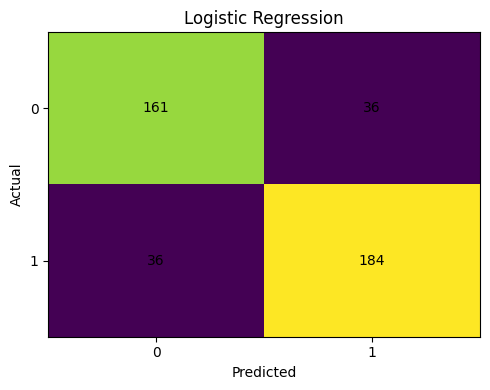

Saved: logreg_confusion_matrix_test.png
Saved: logreg_top_feature_coefficients.csv


In [ ]:
# Logistic Regression on top-K train-correlated features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

TOP_K = 12
SELECT_BY_ABS = True

corr_series = ft_corr.abs() if SELECT_BY_ABS else ft_corr
top_features = corr_series.sort_values(ascending=False).head(TOP_K).index.tolist()
print(f"Top {TOP_K} features:", top_features)

Xtr = X_train[top_features].copy()
Xte = X_test[top_features].copy()

clf = LogisticRegression(max_iter=1000, solver="lbfgs")
clf.fit(Xtr, y_train)

yhat_tr = clf.predict(Xtr)
yhat_te = clf.predict(Xte)

train_acc = accuracy_score(y_train, yhat_tr)
test_acc  = accuracy_score(y_test,  yhat_te)
print(f"Train Acc: {train_acc:.3f}")
print(f"Test  Acc: {test_acc:.3f}")

train_rep = classification_report(y_train, yhat_tr, digits=2)
test_rep  = classification_report(y_test,  yhat_te, digits=2)

with open("logreg_reports.txt","w") as f:
    f.write(f"Train Acc: {train_acc:.3f}\nTest Acc: {test_acc:.3f}\n\n")
    f.write("=== Train Report ===\n" + train_rep + "\n")
    f.write("=== Test Report ===\n"  + test_rep  + "\n")

print("\n=== Train Report ===\n", train_rep)
print("\n=== Test Report ===\n",  test_rep)
print("Saved: logreg_reports.txt")

# confusion matrix (TEST)
cm = confusion_matrix(y_test, yhat_te)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, aspect='auto')
ax.set_title("Logistic Regression")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.savefig("logreg_confusion_matrix_test.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: logreg_confusion_matrix_test.png")

coef_df = pd.DataFrame({"feature": top_features, "coef": clf.coef_.ravel()})
coef_df = coef_df.reindex(coef_df["coef"].abs().sort_values(ascending=False).index)
coef_df.to_csv("logreg_top_feature_coefficients.csv", index=False)
print("Saved: logreg_top_feature_coefficients.csv")


Top 12 features: ['ST slope', 'exercise angina', 'chest pain type', 'oldpeak', 'max heart rate', 'sex', 'age', 'fasting blood sugar', 'cholesterol', 'resting bp s', 'resting ecg']
Best params: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}
Saved: dtree_reports.txt
Saved: dtree_feature_importances.csv


/tmp/ipython-input-2857241640.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


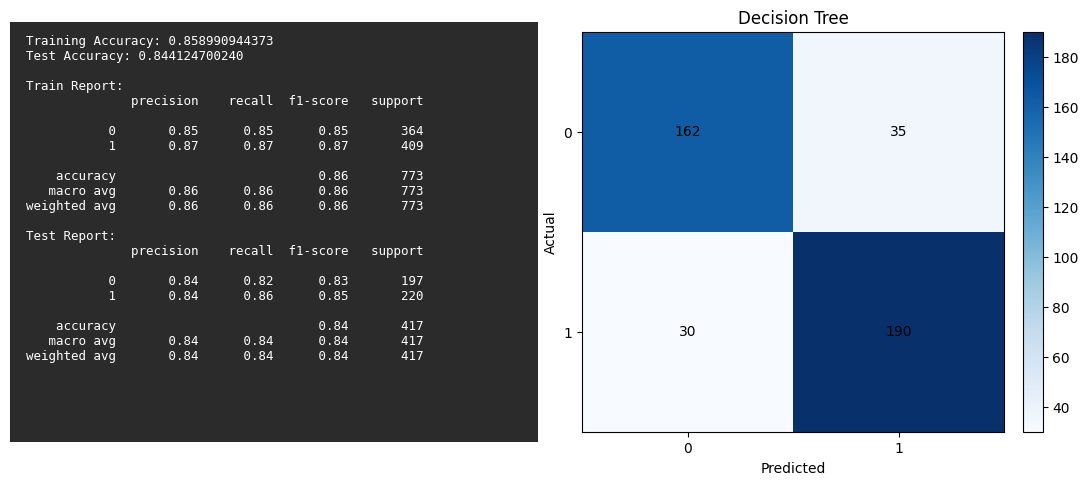

Saved: dtree_dashboard.png
Saved: dtree_structure_top3levels.png


In [ ]:
# Decision Tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

CSV_PATH = "heart.csv"
df = pd.read_csv(CSV_PATH)

TARGET_CANDIDATES = ["output","target","num","disease","heart_disease","presence","class","label"]
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
assert target_col is not None, f"Couldn't detect target; set target_col manually. Columns: {list(df.columns)}"

num_df = df.select_dtypes(include=[np.number]).copy()
y = num_df[target_col]
if y.nunique() > 2:
    y = (y > 0).astype(int)
X = num_df.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

ft_corr = X_train.corrwith(y_train)

TOP_K = 12
SELECT_BY_ABS = True
corr_series = ft_corr.abs() if SELECT_BY_ABS else ft_corr
top_features = corr_series.sort_values(ascending=False).head(TOP_K).index.tolist()
print(f"Top {TOP_K} features:", top_features)

Xtr = X_train[top_features].copy()
Xte = X_test[top_features].copy()

param_grid = {
    "max_depth": [3,4,5,6,8,10,None],
    "min_samples_leaf": [1,2,5,10,20],
    "min_samples_split": [2,5,10,20,50],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005, 0.01],
    "criterion": ["gini","entropy"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=0
)
search.fit(Xtr, y_train)
clf = search.best_estimator_
print("Best params:", search.best_params_)

yhat_tr = clf.predict(Xtr)
yhat_te = clf.predict(Xte)

train_acc = accuracy_score(y_train, yhat_tr)
test_acc  = accuracy_score(y_test,  yhat_te)

train_rep = classification_report(y_train, yhat_tr, digits=2)
test_rep  = classification_report(y_test,  yhat_te, digits=2)

with open("dtree_reports.txt","w") as f:
    f.write(f"Training Accuracy: {train_acc:.12f}\nTest Accuracy: {test_acc:.12f}\n\n")
    f.write("Train Report:\n" + train_rep + "\n")
    f.write("Test Report:\n"  + test_rep  + "\n")
print("Saved: dtree_reports.txt")

fi = pd.Series(clf.feature_importances_, index=top_features).sort_values(ascending=False)
fi.to_csv("dtree_feature_importances.csv", header=["importance"])
print("Saved: dtree_feature_importances.csv")

cm = confusion_matrix(y_test, yhat_te)

fig = plt.figure(figsize=(11,5))
ax_text = fig.add_axes([0.02, 0.08, 0.48, 0.84])
ax_text.set_axis_off()
card = FancyBboxPatch((0,0), 1, 1, boxstyle="round,pad=0.02,rounding_size=0.04",
                      ec="#2b2b2b", fc="#2b2b2b", transform=ax_text.transAxes, zorder=0)
ax_text.add_patch(card)
text = (
    f"Training Accuracy: {train_acc:.12f}\n"
    f"Test Accuracy: {test_acc:.12f}\n\n"
    f"Train Report:\n{train_rep}\n"
    f"Test Report:\n{test_rep}"
)
ax_text.text(0.03, 0.97, text, va="top", ha="left", fontsize=9, family="monospace", color="white")

ax_cm = fig.add_axes([0.54, 0.10, 0.42, 0.80])
im = ax_cm.imshow(cm, cmap="Blues", aspect='auto')
ax_cm.set_title("Decision Tree")
ax_cm.set_xlabel("Predicted"); ax_cm.set_ylabel("Actual")
ax_cm.set_xticks([0,1]); ax_cm.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax_cm.text(j, i, str(cm[i, j]), ha="center", va="center")
cb = fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("dtree_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: dtree_dashboard.png")

plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=top_features, class_names=["0","1"], filled=True, rounded=True, max_depth=3)
plt.tight_layout()
plt.savefig("dtree_structure_top3levels.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: dtree_structure_top3levels.png")

Top 12 features: ['ST slope', 'exercise angina', 'chest pain type', 'oldpeak', 'max heart rate', 'sex', 'age', 'fasting blood sugar', 'cholesterol', 'resting bp s', 'resting ecg']
Best params: {'svc__C': 3, 'svc__class_weight': None, 'svc__gamma': 0.3, 'svc__kernel': 'rbf'}
Saved: svm_reports.txt


/tmp/ipython-input-1572091775.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


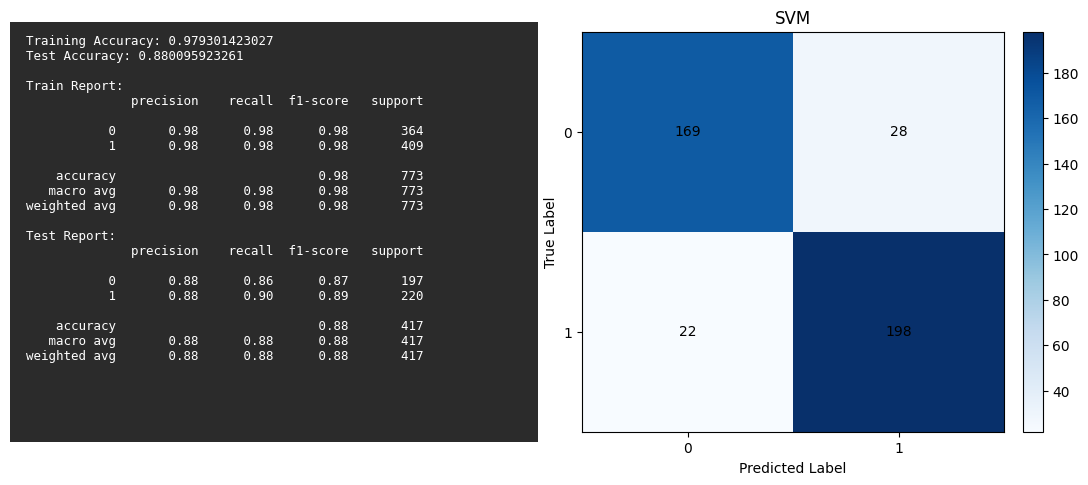

Saved: svm_dashboard.png
Saved: svm_confusion_matrix_test.png


In [ ]:
# SVM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

CSV_PATH = "heart.csv"
df = pd.read_csv(CSV_PATH)

TARGET_CANDIDATES = ["output","target","num","disease","heart_disease","presence","class","label"]
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
assert target_col is not None, f"Couldn't detect target; set target_col manually. Columns: {list(df.columns)}"

num_df = df.select_dtypes(include=[np.number]).copy()
y = num_df[target_col]
if y.nunique() > 2:
    y = (y > 0).astype(int)
X = num_df.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)

ft_corr = X_train.corrwith(y_train)

TOP_K = 12
SELECT_BY_ABS = True
corr_series = ft_corr.abs() if SELECT_BY_ABS else ft_corr
top_features = corr_series.sort_values(ascending=False).head(TOP_K).index.tolist()
print(f"Top {TOP_K} features:", top_features)

Xtr = X_train[top_features].copy()
Xte = X_test[top_features].copy()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

param_grid = {
    "svc__kernel": ["rbf", "linear"],
    "svc__C": [0.1, 1, 3, 10, 30, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.03, 0.1, 0.3, 1],
    "svc__class_weight": [None, "balanced"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)
search.fit(Xtr, y_train)
clf = search.best_estimator_
print("Best params:", search.best_params_)

yhat_tr = clf.predict(Xtr)
yhat_te = clf.predict(Xte)

train_acc = accuracy_score(y_train, yhat_tr)
test_acc  = accuracy_score(y_test,  yhat_te)

train_rep = classification_report(y_train, yhat_tr, digits=2)
test_rep  = classification_report(y_test,  yhat_te, digits=2)

with open("svm_reports.txt","w") as f:
    f.write(f"Training Accuracy: {train_acc:.12f}\nTest Accuracy: {test_acc:.12f}\n")
    f.write(f"Best Params: {search.best_params_}\n\n")
    f.write("Train Report:\n" + train_rep + "\n")
    f.write("Test Report:\n"  + test_rep  + "\n")
print("Saved: svm_reports.txt")

svc_step = clf.named_steps["svc"]
if getattr(svc_step, "kernel", None) == "linear" and hasattr(svc_step, "coef_"):
    coef = pd.Series(svc_step.coef_.ravel(), index=top_features).sort_values(key=lambda s: s.abs(), ascending=False)
    coef.to_csv("svm_linear_coefficients.csv", header=["coef"])
    print("Saved: svm_linear_coefficients.csv")

cm = confusion_matrix(y_test, yhat_te)

fig = plt.figure(figsize=(11,5))
ax_text = fig.add_axes([0.02, 0.08, 0.48, 0.84])
ax_text.set_axis_off()
card = FancyBboxPatch((0,0), 1, 1, boxstyle="round,pad=0.02,rounding_size=0.04",
                      ec="#2b2b2b", fc="#2b2b2b", transform=ax_text.transAxes, zorder=0)
ax_text.add_patch(card)
text = (
    f"Training Accuracy: {train_acc:.12f}\n"
    f"Test Accuracy: {test_acc:.12f}\n\n"
    f"Train Report:\n{train_rep}\n"
    f"Test Report:\n{test_rep}"
)
ax_text.text(0.03, 0.97, text, va="top", ha="left", fontsize=9, family="monospace", color="white")

ax_cm = fig.add_axes([0.54, 0.10, 0.42, 0.80])
im = ax_cm.imshow(cm, cmap="Blues", aspect='auto')
ax_cm.set_title("SVM")
ax_cm.set_xlabel("Predicted Label"); ax_cm.set_ylabel("True Label")
ax_cm.set_xticks([0,1]); ax_cm.set_yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax_cm.text(j, i, str(cm[i, j]), ha="center", va="center")
fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("svm_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: svm_dashboard.png")

plt.figure(figsize=(5,4))
im = plt.imshow(cm, cmap="Blues", aspect='auto')
plt.title("SVM")
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.xticks([0,1]); plt.yticks([0,1])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("svm_confusion_matrix_test.png", dpi=150, bbox_inches="tight")
plt.close()
print("Saved: svm_confusion_matrix_test.png")